In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import backend as K


BASE_DIR = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
IMG_SIZE = (256, 256)
IMG_DIM = (256, 256, 3)
BATCH_SIZE = 40

## Dataset Prepration

In [2]:
images_paths = []
masks_paths = glob(f'{BASE_DIR}/*/*_mask*')

for i in masks_paths:
    images_paths.append(i.replace('_mask', ''))

data = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

train_df, tmp = train_test_split(data, test_size=0.2)
test_df, val_df = train_test_split(tmp, test_size=0.5)

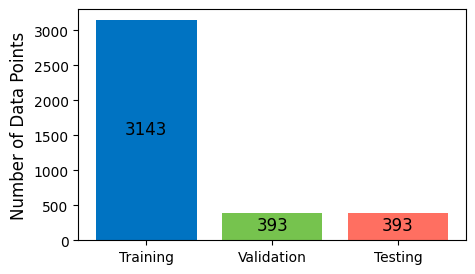

In [18]:
categories = ['Training', 'Validation', 'Testing']
counts = [train_df.shape[0], val_df.shape[0], test_df.shape[0]]
colors = ['#0073C2FF', '#76C34EFF', '#FF6F61FF']

fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.bar(categories, counts, color=colors)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height/2 - 60, f'{height}', ha='center', fontsize=12)

ax.set_ylabel('Number of Data Points', fontsize=12)
plt.show()


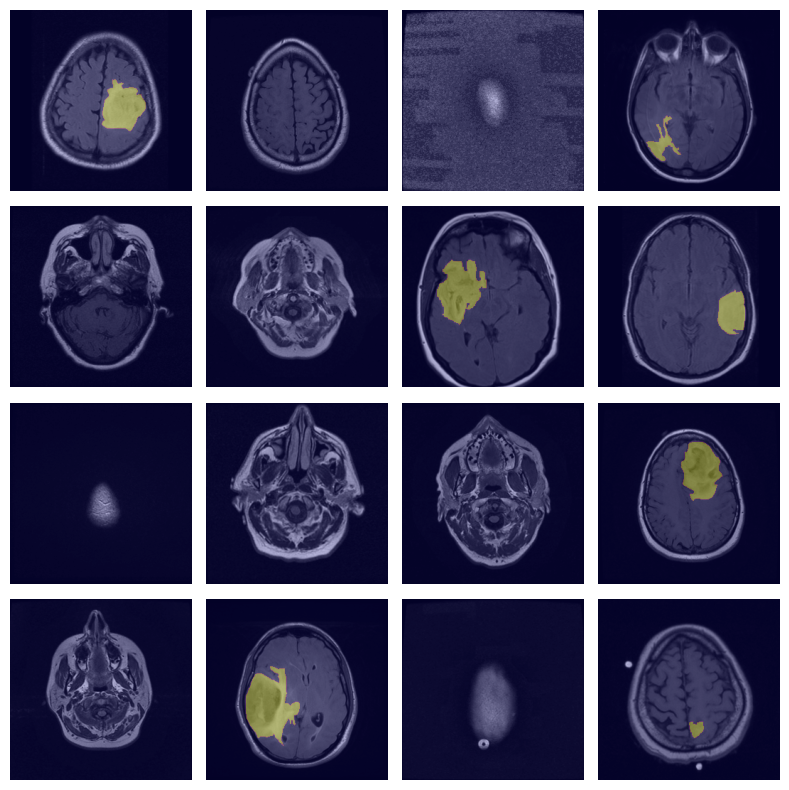

In [16]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img_path = list(train_df['images_paths'])[i]
    mask_path = list(train_df['masks_paths'])[i]

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='plasma', alpha=0.3)

    plt.axis('off')

plt.tight_layout()
plt.show()


## Augmentation

In [9]:
augmentation = {
    'zoom_range':0.2,                
   'rotation_range':25,             
    'horizontal_flip':True,        
    'vertical_flip':True,         
    'brightness_range':[0.8, 1.2]
}

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Found 3143 validated image filenames.
Found 3143 validated image filenames.


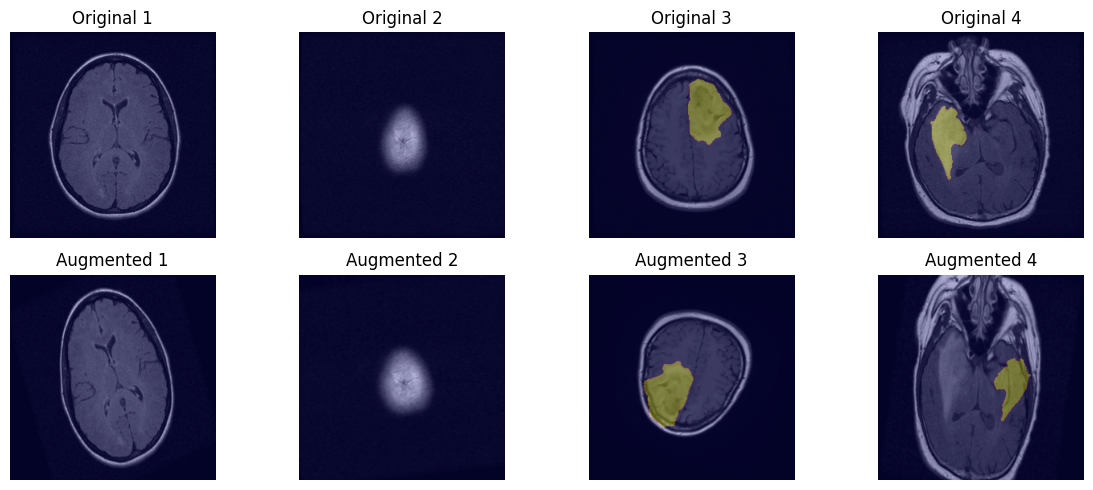

In [80]:
simple = ImageDataGenerator(
    rescale=1.0 / 255
)

augmentated = ImageDataGenerator(
    rescale=1.0 / 255,
    **augmentation
)


image_simple_gen = simple.flow_from_dataframe(train_df, x_col='images_paths', class_mode=None, color_mode='grayscale', target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE, save_to_dir=None, save_prefix='image', shuffle=False)

mask_simple_gen = simple.flow_from_dataframe(train_df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE, save_to_dir=None, save_prefix= 'mask', shuffle=False)


image_aug_gen = augmentated.flow_from_dataframe(train_df, x_col='images_paths', class_mode=None, color_mode='grayscale', target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE, save_to_dir=None, save_prefix='image', shuffle=False)

mask_aug_gen = augmentated.flow_from_dataframe(train_df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE, save_to_dir=None, save_prefix= 'mask', shuffle=False)


simple_gen = zip(image_simple_gen, mask_simple_gen)
aug_gen = zip(image_aug_gen, mask_aug_gen)

def plot_images(simple, augmentated, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(3 * num_images, 5))
    simple_batch = next(simple)
    augmentated_batch = next(augmentated)

    for i in range(num_images):
        original_image = simple_batch[0][i]
        original_mask = simple_batch[1][i].squeeze()

        augmented_image = augmentated_batch[0][i]
        augmented_mask = augmentated_batch[1][i].squeeze()

        axes[0, i].imshow(original_image,  cmap="gray")
        axes[0, i].imshow(original_mask, cmap="plasma", alpha=0.3)
        axes[0, i].set_title(f"Original {i + 1}")
        axes[0, i].axis("off")

        axes[1, i].imshow(augmented_image,  cmap="gray")
        axes[1, i].imshow(augmented_mask, cmap="plasma", alpha=0.3)
        axes[1, i].set_title(f"Augmented {i + 1}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

plot_images(simple_gen, aug_gen, num_images=4)

## Loss Function and Metrics

In [7]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou_score(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

## Training the Model

In [5]:
def provide_gens(data, aug={}, train=False):
    generator = ImageDataGenerator(
    # rescale=1.0 / 255,
        **aug
    )
    image_gen = generator.flow_from_dataframe(data, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=IMG_SIZE, batch_size=BATCH_SIZE, save_to_dir=None, save_prefix='image', shuffle=train, seed=1)

    mask_gen = generator.flow_from_dataframe(data, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=IMG_SIZE, batch_size=BATCH_SIZE, save_to_dir=None, save_prefix= 'mask', shuffle=train, seed=1)
    
    for (image, mask) in zip(image_gen, mask_gen):
        image = image / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        yield (image, mask) 

In [17]:
class UNet_VGG16:
    def __init__(self, train_df, val_df, test_df):
        self.inputs = Input(IMG_DIM)
        self.vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=self.inputs)
        for layer in self.vgg16.layers:
            layer.trainable = False
        self.build()
        self.train_gen = provide_gens(train_df, aug=augmentation, train=True)
        self.val_gen = provide_gens(val_df, aug={}, train=False)
        self.test_gen = provide_gens(test_df, aug={}, train=False)
        
    def conv_block(self, input, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(input)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
        
    def decoder_block(self, input, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
        x = Concatenate()([x, skip_features])
        x = self.conv_block(x, num_filters)
        return x

    def build(self):
        # VGG16 as Encoder
        skip1 = self.vgg16.get_layer("block1_conv2").output       ## (256 x 256)
        skip2 = self.vgg16.get_layer("block2_conv2").output       ## (128 x 128)
        skip3 = self.vgg16.get_layer("block3_conv3").output       ## (64 x 64) 
        skip4 = self.vgg16.get_layer("block4_conv3").output       ## (32 x 32)
    
        # Bridge
        bridge = self.vgg16.get_layer("block5_conv3").output      ## (16 x 16)
    
        # Rest of U-Net as Decoder
        decoder1 = self.decoder_block(bridge, skip4, 512)         ## (32 x 32)
        decoder2 = self.decoder_block(decoder1, skip3, 256)       ## (64 x 164)
        decoder3 = self.decoder_block(decoder2, skip2, 128)       ## (128 x 128)
        decoder4 = self.decoder_block(decoder3, skip1, 64)        ## (256 x 256)
    
        # Output
        outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder4)
    
        self.model = Model(self.inputs, outputs, name="UNet_VGG16")
        self.model.compile(Adam(learning_rate=0.001), loss=dice_loss, metrics=['accuracy', iou_score, dice_coef])
        return self.model
        
    def summary(self):
        return self.model.summary(expand_nested=False, show_trainable=True)

    def fit(self, epochs=20):
        callbacks = [ModelCheckpoint('weights.keras', verbose=0, save_best_only=True)]

        self.history = self.model.fit(
                    self.train_gen,
                    steps_per_epoch=len(train_df) // BATCH_SIZE,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data = self.val_gen,
                    validation_steps=len(val_df) // BATCH_SIZE
                )
        return self.history
    

In [45]:
model = UNet_VGG16(train_df, val_df, test_df)
# model = model.build()
model.summary()
history = model.fit(45)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "UNet_VGG16"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 256,     │         0 │ -              │   -   │
│ (InputLayer)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 256,     │     1,792 │ input_layer[0… │   N   │
│ (Conv2D)          │ 256, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 256,     │    36,928 │ block1_conv1[… │   N   │
│ (Conv2D)          │ 256, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_pool       │ (None, 128,     │         0 │ block1_conv2[… │   -   │
│ (MaxPooling2D)    │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_conv1      │ (None, 128,     │    73,856 │ block1_pool[0… │   N   │
│ (Conv2D)          │ 128, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_conv2      │ (None, 128,     │   147,584 │ block2_conv1[… │   N   │
│ (Conv2D)          │ 128, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 64, 64,  │         0 │ block2_conv2[… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_conv1      │ (None, 64, 64,  │   295,168 │ block2_pool[0… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_conv2      │ (None, 64, 64,  │   590,080 │ block3_conv1[… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_conv3      │ (None, 64, 64,  │   590,080 │ block3_conv2[… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_pool       │ (None, 32, 32,  │         0 │ block3_conv3[… │   -   │
│ (MaxPooling2D)    │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block4_conv1      │ (None, 32, 32,  │ 1,180,160 │ block3_pool[0… │   N   │
│ (Conv2D)          │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block4_conv2      │ (None, 32, 32,  │ 2,359,808 │ block4_conv1[… │   N   │
│ (Conv2D)          │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block4_conv3      │ (None, 32, 32,  │ 2,359,808 │ block4_conv2[… │   N   │
│ (Conv2D)          │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block4_pool       │ (None, 16, 16,  │         0 │ block4_conv3[… │   -   │
│ (MaxPooling2D)    │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block5_conv1      │ (None, 16, 16,  │ 2,359,808 │ block4_pool[0… │   N   │
│ (Conv2D)          │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block5_conv2      │ (None, 16, 16,  │ 2,359,808 │ block5_conv1[… │   N 

 Total params: 25,862,337 (98.66 MB)

 Trainable params: 11,143,809 (42.51 MB)

 Non-trainable params: 14,718,528 (56.15 MB)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/45


I0000 00:00:1733474986.524022     203 service.cc:145] XLA service 0x7a43ac028f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733474986.524095     203 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733475057.481342     203 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8854 - dice_coef: 0.1411 - iou_score: 0.0803 - loss: -0.1411Found 393 validated image filenames.
Found 393 validated image filenames.
78/78 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8862 - dice_coef: 0.1425 - iou_score: 0.0813 - loss: -0.1425 - val_accuracy: 0.2235 - val_dice_coef: 0.0284 - val_iou_score: 0.0145 - val_loss: -0.0284
Epoch 2/45
78/78 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9929 - dice_coef: 0.5844 - iou_score: 0.4238 - loss: -0.5813 - val_accuracy: 0.9067 - val_dice_coef: 0.1513 - val_iou_score: 0.0824 - val_loss: -0.1521
Epoch 3/45
78/78 ━━━━━━━━━━━━━━━━━━━━ 69s 883ms/step - accuracy: 0.9934 - dice_coef: 0.6716 - iou_score: 0.5202 - loss: -0.6687 - val_accuracy: 0.9908 - val_dice_coef: 0.5859 - val_iou_score: 0.4170 - val_loss: -0.5875
Epoch 4/45
78/78 ━━━━━━━━━━━━━━━━━━━━ 67s 858ms/step - accuracy: 0.9940 - dice_coef: 0.6500 - iou_score: 0.5149 - loss: -0.6555 - val_accuracy: 0.9563 - val_dice_coef: 0.27

In [46]:
# model.model.load_weights('/kaggle/working/weights.keras')

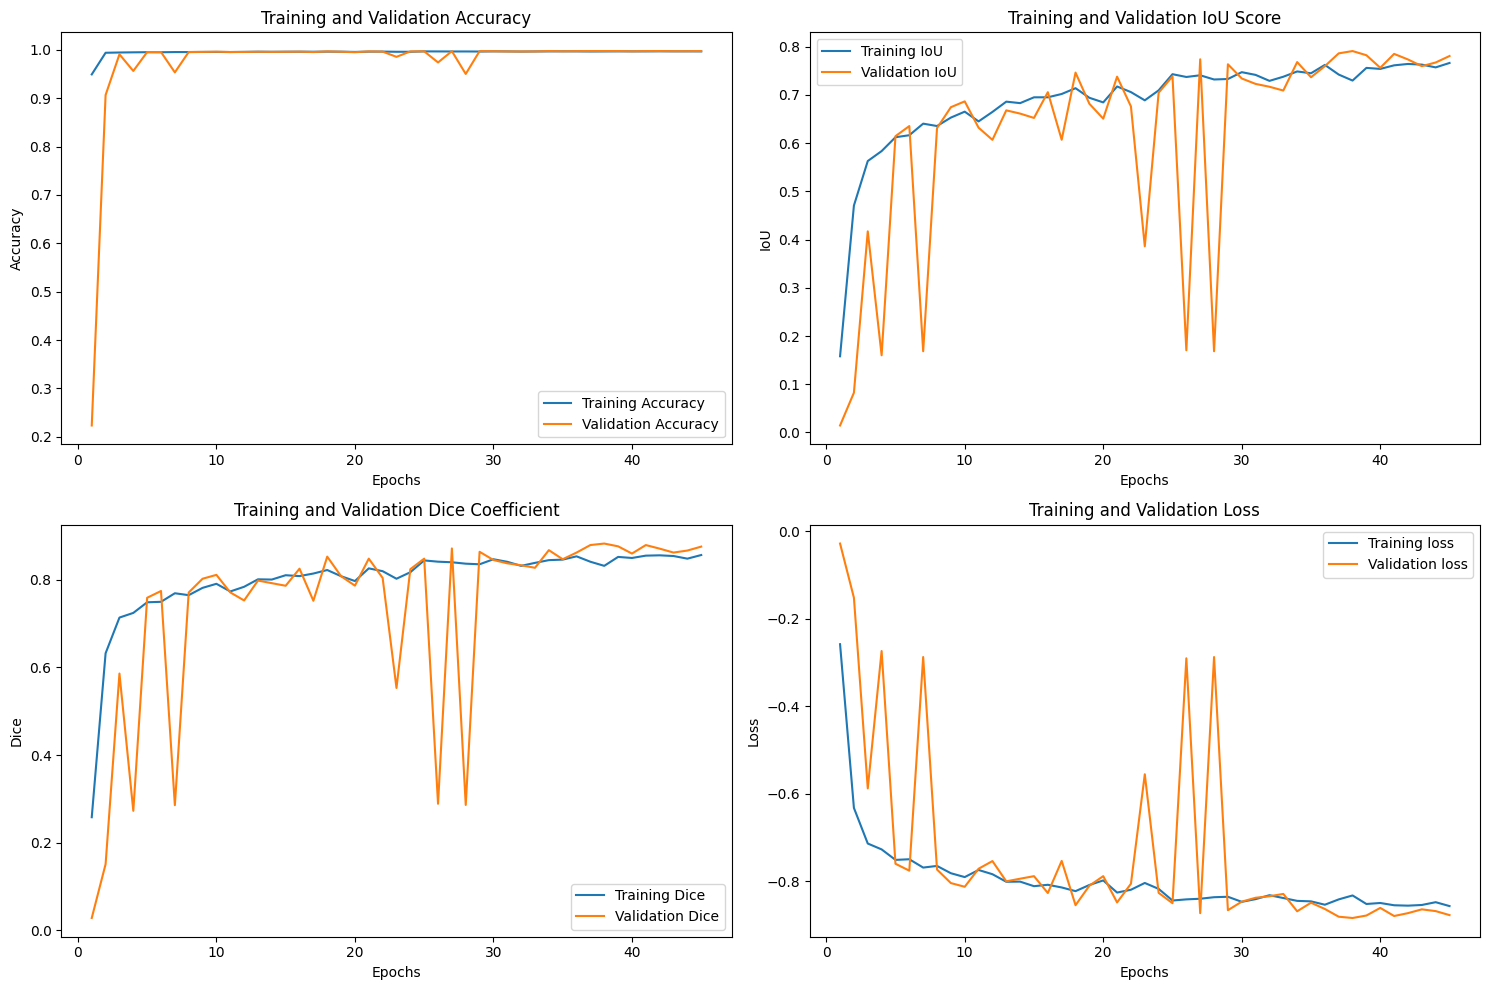

In [54]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_score']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_score']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]
  
    plt.figure(figsize= (15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, label= 'Training IoU')
    plt.plot(Epochs, val_iou, label= 'Validation IoU')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, label= 'Training Dice')
    plt.plot(Epochs, val_dice, label= 'Validation Dice')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

## Prediction

**<span style="color:red; font-size:30px;">DISCLAIMER:</span>**  
<span style="font-size:18px;">Since I ran the prediction part multiple times after writing the report, the shown plot is not the same as the report's one. This is not an error and is inevitable due to the randomness of choosing the data for prediction from test dataset. <br> The proof for the authencity of the report's plot is the plots of loss and metrics in Training section which are same as the report.</span>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


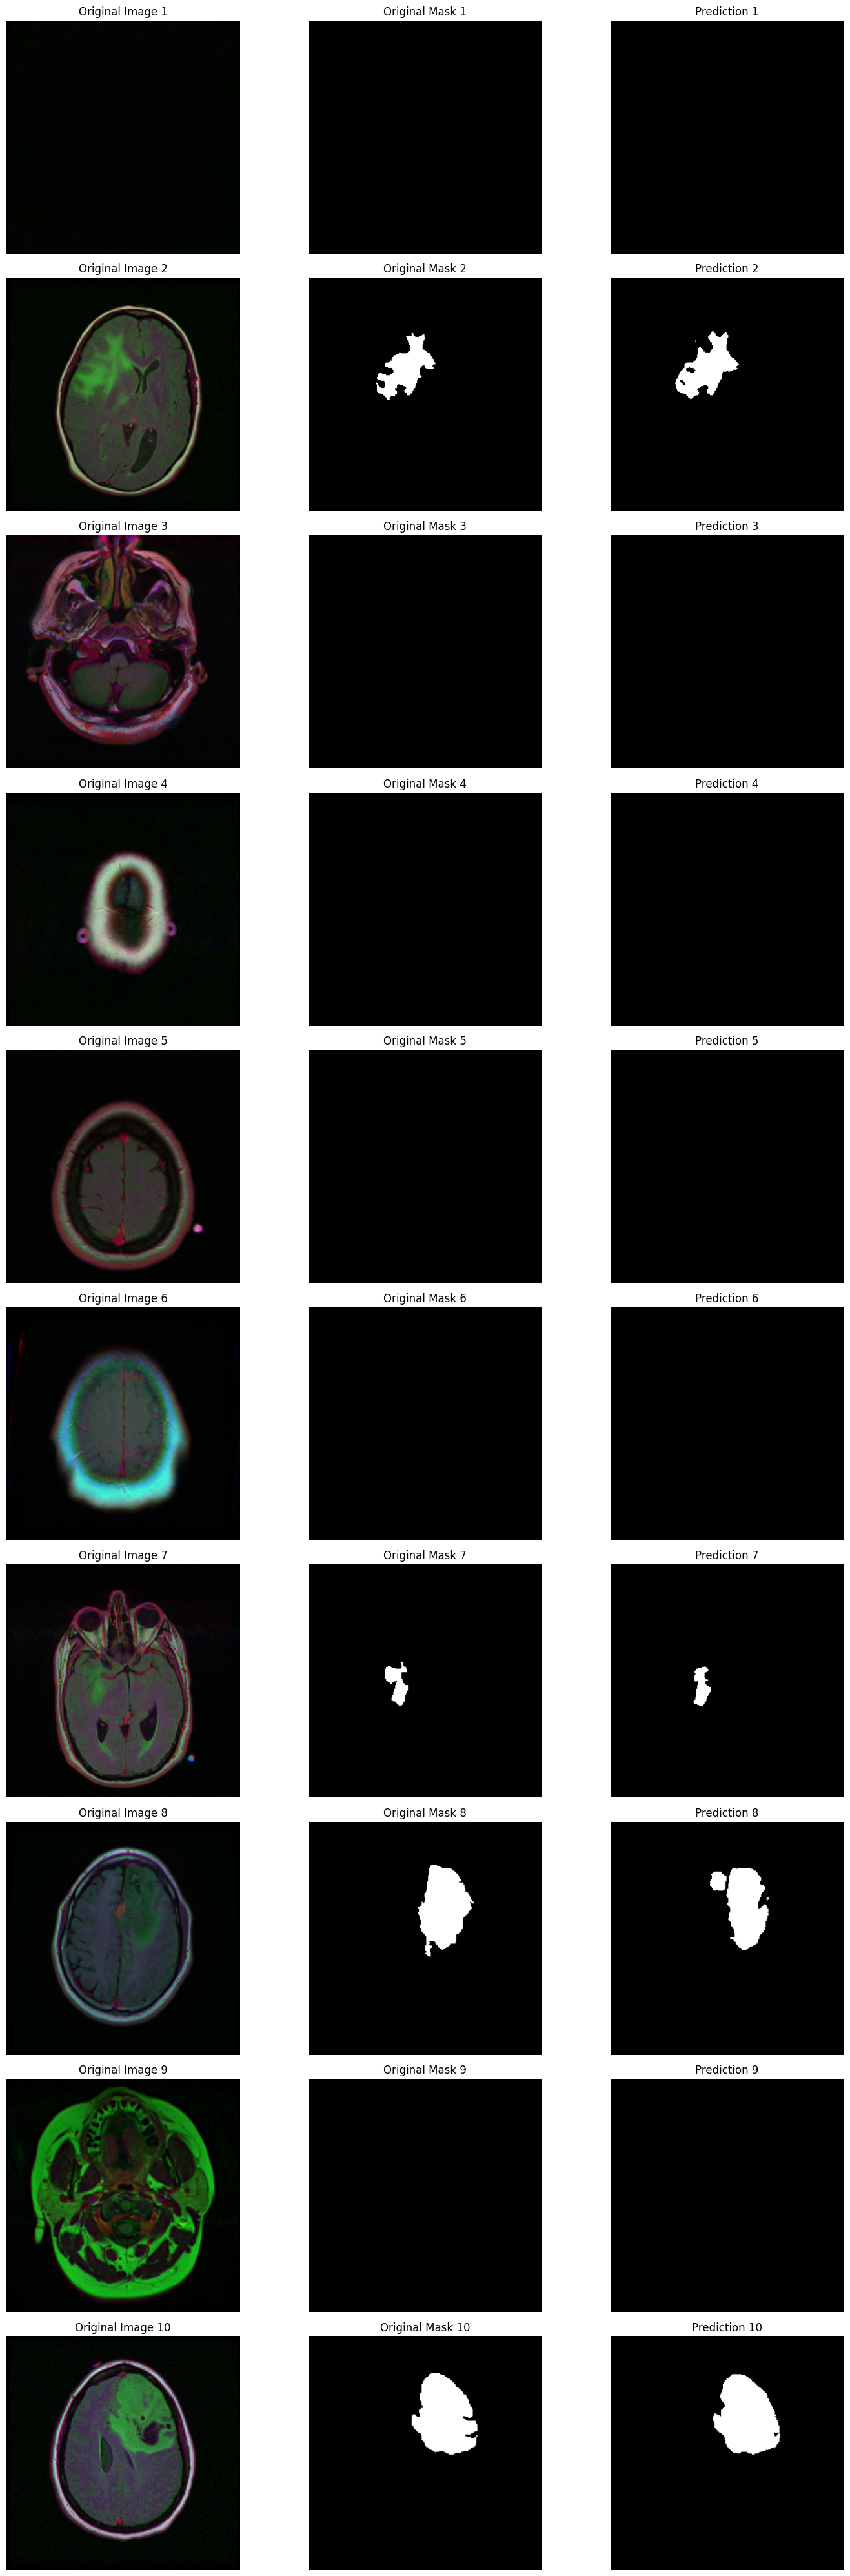

In [79]:
fig, axes = plt.subplots(10, 3, figsize=(15, 40))

for i in range(10):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = img[np.newaxis, :, :, :]

    predicted_img = model.model.predict(img)
    
    axes[i, 0].imshow(np.squeeze(img))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image ' + str(i+1))

    
    original_mask = cv2.imread(test_df['masks_paths'].iloc[index], cv2.IMREAD_GRAYSCALE)
    axes[i, 1].imshow(original_mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Original Mask ' + str(i+1))

    
    axes[i, 2].imshow(np.squeeze(predicted_img) > 0.5, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Prediction ' + str(i+1))

# Adjust layout
plt.tight_layout()
plt.show()


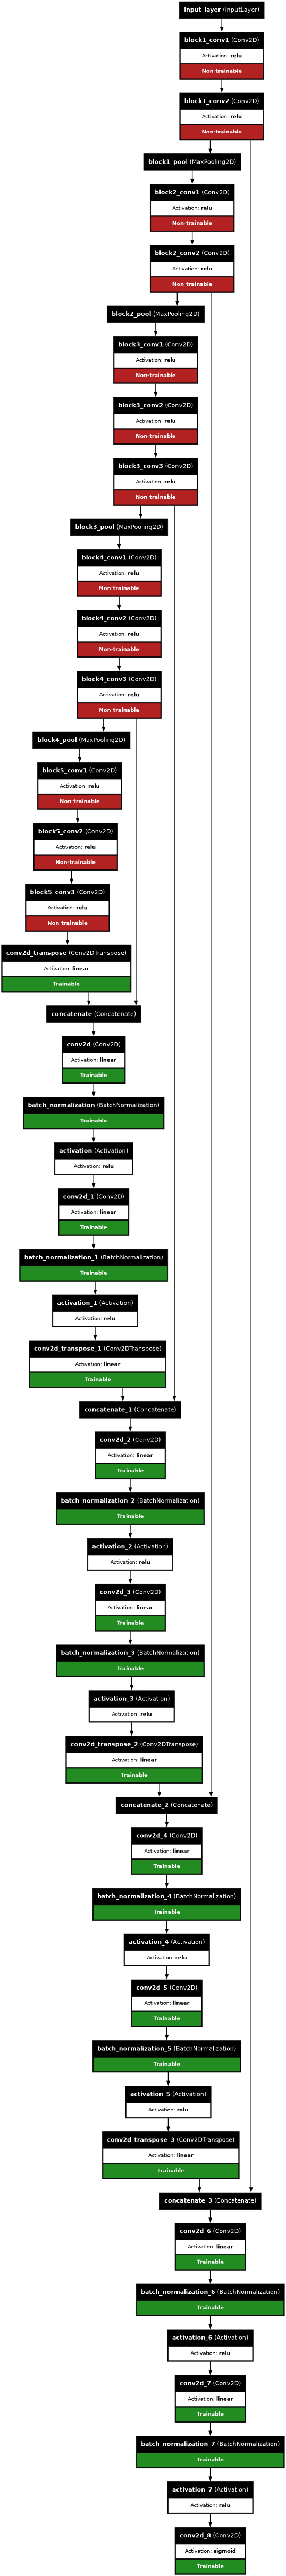

In [71]:
from keras.utils import plot_model
plot_model(model.model, to_file='model.png', show_layer_names=True, dpi=50, show_layer_activations=True, show_trainable=True)